In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

from dateutil.parser import parse
from datetime import timedelta
from tqdm import tqdm

### 데이터 불러오기

In [2]:
data = pd.read_csv("data/0mA(3s)-100mA(1s)-40mA(7s)x10-0mA(40s)_normal+EDLC.csv") #통합 데이터
data.head()

Time  Voltage(V)  Current(A)  Resistance(Ohm)  Power(W)
0  2021-11-09 오후 5:29:30      2.8765      0.0000            0.000     0.000
1  2021-11-09 오후 5:29:31      2.8939      0.0004        12232.813     0.001
2  2021-11-09 오후 5:29:31      2.9114      0.0002        12232.813     0.001
3  2021-11-09 오후 5:29:31      2.9114      0.0002         4033.345     0.002
4  2021-11-09 오후 5:29:31      2.9284      0.0007         4033.345     0.002

### 데이터 자르기 (time, volt, current)

In [3]:
data = data.iloc[:, :3] #.values

### 기준 전압 인덱스 구하기

#### 통신 전류 기준을 잡는 것도 중요할 것 같음
- 문제: 통신 전류는 0이 아닌 0.010, 0.009 등도 포함하지 않으면 갑자기 전압 사용량이 적어지는 것 같은 현상이 발생

In [54]:
comm_A = np.where(data['Current(A)'] > 0.0900) #통신 전류

In [17]:
comm_A[0][0]

96

#### 통신 전류 시작 인덱스 하나만

In [83]:
#첫 번째 인덱스는 넣어두고 시작
comm_ = np.array(comm_A[0][0])

for idx in range(int(len(comm_A[0]))-1):
    #현재 값+1과 다음값이 같지 않으면 연속된 숫자가 아니라는 것으로 추가함
    if comm_A[0][idx]+1 != comm_A[0][idx+1]:
        comm_ = np.append(comm_, comm_A[0][idx+1])

In [84]:
comm_

array([    96,    140,    185, ..., 291428, 291474, 291520], dtype=int64)

#### 사이클이 10번 반복되기 때문에 현재+9까지는 없어야 함

In [85]:
comm_.shape

(4758,)

##### 오류가 나는 이유는 10개의 주기가 없는 경우가 있기 때문(중간에 끊어져서)

In [95]:
comm = np.array([], dtype=int)

for i in range(0, len(comm_), 10):
    comm = np.append(comm, comm_[i])
    comm = np.append(comm, comm_[i+9])

IndexError: index 4759 is out of bounds for axis 0 with size 4758

In [96]:
comm

array([    96,    501,    710,   1102,   1304,   1703,   1919,   2321,
         2527,   2925,   3131,   3534,   3740,   4138,   4343,   4743,
         4947,   5341,   5550,   5945,   6149,   6542,   6747,   7140,
         7344,   7739,   7953,   8359,   8560,   8952,   9163,   9563,
         9769,  10165,  10378,  10774,  10978,  11377,  11582,  11977,
        12180,  12577,  12783,  13177,  13383,  13778,  13983,  14380,
        14582,  14976,  15180,  15577,  15779,  16172,  16388,  16784,
        16989,  17388,  17595,  17990,  18194,  18591,  18796,  19195,
        19401,  19794,  20001,  20402,  20604,  20998,  21202,  21600,
        21807,  22204,  22407,  22805,  23008,  23405,  23612,  24013,
        24221,  24618,  24824,  25225,  25429,  25828,  26034,  26439,
        26644,  27041,  27248,  27643,  27848,  28247,  28453,  28854,
        29058,  29458,  29662,  30063,  30267,  30664,  30882,  31300,
        31508,  31922,  32128,  32530,  32734,  33132,  33336,  33734,
      

In [97]:
comm.shape

(951,)

#### 기준 전압은 통신 시작 전류 인덱스 바로 전

In [98]:
t_crit = comm - 1

In [99]:
t_crit.shape

(951,)

In [103]:
if t_crit.shape[0]%2 != 0:
    t_crit = t_crit[:-1]

#### 인덱스 조정: 전압이 떨어지는 순간부터

In [111]:
ref = np.array([], dtype=int)

for t in tqdm(t_crit):
    tmp = t  #tmp는 >0.020 이전의 전압 인덱스
    
    for i in range(1, 5): #4번 loop
        #전압(+): t < t-1
        if (data['Voltage(V)'][tmp] < data['Voltage(V)'][t-i]):
            #t-1 > t-2 => 인덱스 변경: t-i
            if data['Voltage(V)'][t-i] >= data['Voltage(V)'][t-i-1]: #이전 이전의 전압이 더 작으면
                tmp = t-i
                break
            else:
                tmp = t- i
        #전압 (-), 전류 (+) => 인덱스 변경: t-i
        elif (data['Voltage(V)'][tmp] > data['Voltage(V)'][t-i]) and (data['Current(A)'][tmp] < data['Current(A)'][t-i]) and (data['Current(A)'][tmp] != 0.0000) and (data['Current(A)'][t-i] > 0.020):
            tmp = t-i
        #전압(-) => 인덱스 유지
        elif data['Voltage(V)'][tmp] > data['Voltage(V)'][t-i]:
            break
        #전압이 같음: t == t-1
        elif data['Voltage(V)'][tmp] == data['Voltage(V)'][t-i]:
            #t-1 < t-2 => 인덱스 변경: t-i-1
            if data['Voltage(V)'][t-i] < data['Voltage(V)'][t-i-1]:
                tmp = t-i-1
                break
            
    ref = np.append(ref, tmp)
            
ref = np.unique(ref) #중복 값 제거

100%|██████████████████████████████████████████████████████████████████████████████| 950/950 [00:00<00:00, 7544.31it/s]


### 전압 회복 시간, 회복률, 전압을 확인하기 위함
- recovery_time [[통신 전, crit_time]]
- recovery_rate [[통신 중(최대), crit_rate]]
- recovery_volt [[통신 전, 통신 중(최소), crit_volt]]
- crit = 기준 전압 회복률
- 회복률이 crit 이하가 되거나 0이 아니면 다음 통신 데이터로
    - 기준 전압과 통신 전압이 같은 부분이 있어 이상한 데이터가 그려짐 (회복률이 0이 아니면)
- np.delete()하는 이유는 처음에 np.zeros(())로 만들었기 때문에 제일 처음에 0 값이 들어가 있음
    - np.empty(())를 사용하면 쓰레기 값이 들어가 있음 (어차피 같음)

In [116]:
recovery_time=np.zeros((1,2)) #시간은 통신 전, 회복(crit) 시간
recovery_rate=np.zeros((1,2), dtype=int) #통신(최대), crit(0.5 or smaller)
recovery_volt=np.zeros((1,3), dtype=int) #통신전, 통신(최소), 회복
index = np.zeros((1,2))

crit = 0.50

for i in tqdm(range(0, len(ref), 2)): #기준 전압
    r = np.array([]) #max을 구하기 위해서 rate값을 넣을 배열을 생성
    v = np.array([]) #min을 구하기 위해서 volt값을 넣을 배열을 생성
    
    idx = ref[i]
    idx2 = ref[i+1]+1
#     length = t_crit[i+2] - t_crit[i+1]
    for j in range(1, 200):
        rate = (data['Voltage(V)'][idx] - data['Voltage(V)'][idx2+j])/data['Voltage(V)'][idx] * 100 #(기준전압 - 현재전압)/기준전압 *100
        r = np.append(r, np.array([rate])) #배열에 위에서 구한 전압 변화율 추가
        v = np.append(v, np.array([data['Voltage(V)'][idx2+j]])) #배열에 현재 전압값 추가

        #회복 전압이면 반복을 멈추고 각 배열에 요소 추가
        # 1. 현재 전압 < 다음 전압 && 2. 다음 전류가 0.020보다 작을 때 && 3. 현재 전압 변화율 <= 기준 전압 변화율 && 4. 전압 변화율 != 0
        if (data['Voltage(V)'][idx2+j] < data['Voltage(V)'][idx2+j+1]) and (data['Current(A)'][idx2+j+1] < 0.020) and (rate <= crit) and (rate != 0.0000):
            #전압 변화율 추가(최대 전압 변화율(최저 전압), 현재 전압 변화율)
            recovery_rate = np.append(recovery_rate, np.array([np.max(r), rate]).reshape(1,2), axis=0)
            #전압 회복 시간(기준 전압 시간, 회복 전압 시간)
            recovery_time = np.append(recovery_time, np.array([data['Time'][idx], data['Time'][idx2+j]]).reshape(1,2), axis=0)
            #전압(기준 전압, 최저 전압, 회복 전압)
            recovery_volt = np.append(recovery_volt, np.array([data['Voltage(V)'][idx], np.min(v), data['Voltage(V)'][idx2+j]]).reshape(1,3), axis=0)

            index = np.append(index, np.array([idx, (idx2+j)]).reshape(1,2), axis=0)
            break
            
recovery_rate = np.delete(recovery_rate, 0, 0)
recovery_time = np.delete(recovery_time, 0, 0)
recovery_volt = np.delete(recovery_volt, 0, 0)
index = np.delete(index, 0, 0)

100%|███████████████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 104.32it/s]


### 시간을 timedelt로 변경하기 위함

In [117]:
date_=[] #replace korean to english

for i in recovery_time.flatten():
    i = i.replace("오전", "AM")
    i = i.replace("오후", "PM")
    date_.append(i)
    
date__=[] #split blank

for i in date_:
    date__.append(i.split(" "))
    
date___=[] #switch index

for i in date__: #위치 변경
    tmp = i[1] 
    i[1] = i[2]
    i[2] = tmp
    date___.append(i)
    
parsing_date=[]

for i in tqdm(date___):
    #print('parsing: ', i, "=", (" ").join(i))
    dt = parse((" ").join(i)) #list to string
    #print(dt)
    #print()
    parsing_date.append(dt)
    
recovery_time = np.array(parsing_date).reshape(recovery_time.shape[0], 2)

100%|██████████████████████████████████████████████████████████████████████████████| 950/950 [00:00<00:00, 9841.21it/s]


### 그래프를 그려 변화 확인

#### 통신시에 전압을 얼마나 사용하는지 볼 수 있음

*normal+edlc -> 10 cycles*

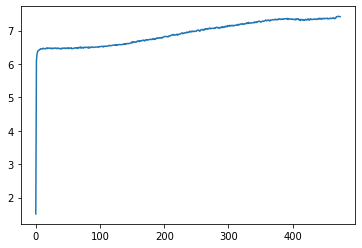

In [118]:
plt.plot(np.max(recovery_rate[:], axis=1))

In [119]:
recovery_time[400]

array([datetime.datetime(2021, 11, 10, 10, 9, 53),
       datetime.datetime(2021, 11, 10, 10, 12, 10)], dtype=object)

In [68]:
max_rate = np.max(recovery_rate[:], axis=1)

In [121]:
f = open("NORMAL+EDLC(0-100-40).csv", "w")
f.write("max_rate\n")

for i in range(int(len(max_rate))):
    f.write(str(max_rate[i]) + "\n")
    
f.close()

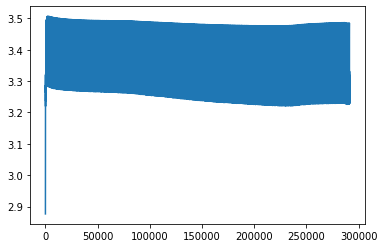

In [120]:
plt.plot(data['Voltage(V)'][:])

In [71]:
index[1052]

array([46032., 46085.])

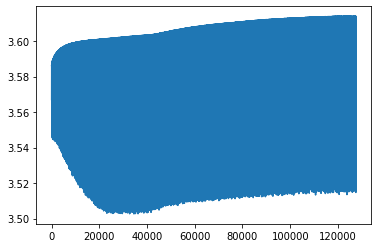

In [82]:
plt.plot(data['Voltage(V)'][:127600])

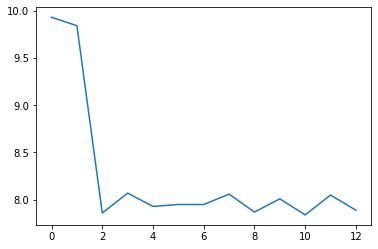

In [78]:
plt.plot(np.max(recovery_rate[1052:1065], axis=1)) #ref(normal_merge)

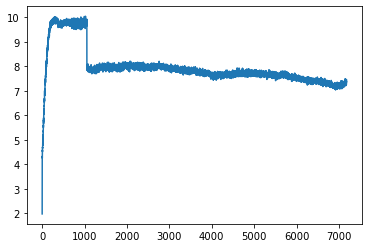

In [59]:
plt.plot(np.max(recovery_rate[:], axis=1)) #ref(normal_1)

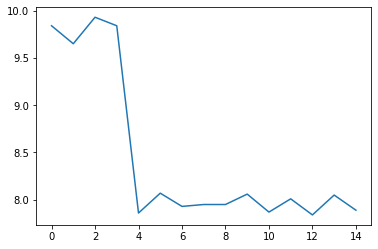

In [21]:
plt.plot(np.max(recovery_rate[1050:1065], axis=1)) #ref(normal_merge)

#### 전압 변화율이 급감하는 부분

In [22]:
np.max(recovery_rate[1050:1065], axis=1)

array([9.84, 9.65, 9.93, 9.84, 7.86, 8.07, 7.93, 7.95, 7.95, 8.06, 7.87,
       8.01, 7.84, 8.05, 7.89])

In [28]:
np.argmin(np.max(recovery_rate[120:125], axis=1))

3

In [35]:
np.max(recovery_rate[120:125], axis=1)

array([8.52, 8.65, 8.56, 8.77, 8.62])

In [49]:
recovery_time[1050:1060]

array([[datetime.datetime(2021, 10, 16, 0, 18, 26),
        datetime.datetime(2021, 10, 16, 0, 18, 27)],
       [datetime.datetime(2021, 10, 16, 0, 18, 55),
        datetime.datetime(2021, 10, 16, 0, 18, 58)],
       [datetime.datetime(2021, 10, 16, 0, 19, 26),
        datetime.datetime(2021, 10, 16, 0, 19, 27)],
       [datetime.datetime(2021, 10, 16, 0, 19, 55),
        datetime.datetime(2021, 10, 16, 0, 19, 58)],
       [datetime.datetime(2021, 10, 18, 9, 39, 25),
        datetime.datetime(2021, 10, 18, 9, 39, 27)],
       [datetime.datetime(2021, 10, 18, 9, 39, 55),
        datetime.datetime(2021, 10, 18, 9, 39, 57)],
       [datetime.datetime(2021, 10, 18, 9, 40, 25),
        datetime.datetime(2021, 10, 18, 9, 40, 27)],
       [datetime.datetime(2021, 10, 18, 9, 40, 55),
        datetime.datetime(2021, 10, 18, 9, 40, 57)],
       [datetime.datetime(2021, 10, 18, 9, 41, 25),
        datetime.datetime(2021, 10, 18, 9, 41, 27)],
       [datetime.datetime(2021, 10, 18, 9, 41, 55),
   

In [50]:
recovery_volt[1050:1060]

array([[3.6139, 3.5155, 3.6095],
       [3.614 , 3.5175, 3.6099],
       [3.614 , 3.5147, 3.6094],
       [3.614 , 3.5156, 3.6098],
       [3.6132, 3.5346, 3.6092],
       [3.6132, 3.5325, 3.6088],
       [3.6132, 3.5339, 3.6091],
       [3.6132, 3.5337, 3.6087],
       [3.6133, 3.5338, 3.6091],
       [3.6132, 3.5326, 3.6088]])

In [ ]:
recovery_time

#### 시간은 timedelt형으로 되어 있기 때문에 회복 시간을 보기 위해서는 처리가 필요

In [111]:
re_time = np.array([])
for i in recovery_time:
    re_time = np.append(re_time, np.array((i[1]-i[0]).seconds))

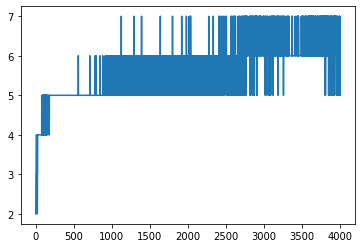

In [113]:
plt.plot(re_time)

#### 통신 전, 통신 중, 회복 전압 그래프

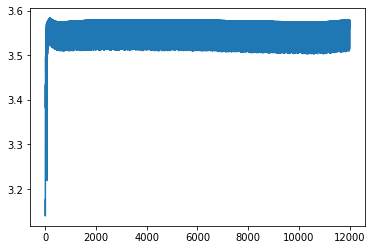

In [114]:
plt.plot(recovery_volt[:].flatten())